In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [2]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [3]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [4]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [5]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [6]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])

In [7]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [8]:
# 构建网络
model = Sequential() 
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

In [9]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V7_3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
22/28 [======================>.......] - ETA: 0s - loss: 0.6545 - accuracy: 0.6804
Epoch 00001: val_accuracy improved from -inf to 0.57753, saving model to BiLSTM_V7_3.h5
28/28 [==============================] - 1s 38ms/step - loss: 0.6360 - accuracy: 0.6905 - val_loss: 0.7151 - val_accuracy: 0.5775 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8104
Epoch 00002: val_accuracy did not improve from 0.57753
28/28 [==============================] - 0s 9ms/step - loss: 0.4190 - accuracy: 0.8104 - val_loss: 0.6563 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8604
Epoch 00003: val_accuracy improved from 0.57753 to 0.63371, saving model to BiLSTM_V7_3.h5
28/28 [==============================] - 0s 11ms/step - loss: 0.3245 - accuracy: 0.8604 - val_loss: 0.6436 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 4/200
22/28 [======================>.......] - 

Epoch 29/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0088 - accuracy: 0.9993
Epoch 00029: val_accuracy did not improve from 0.79326
28/28 [==============================] - 0s 9ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.8425 - val_accuracy: 0.7236 - lr: 5.0000e-04
Epoch 30/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.79326
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.5665 - val_accuracy: 0.7843 - lr: 5.0000e-04
Epoch 31/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 00031: val_accuracy improved from 0.79326 to 0.80000, saving model to BiLSTM_V7_3.h5
28/28 [==============================] - 0s 10ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5525 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 32/200
23/28 [=======================>......] - ETA: 0s - loss: 0.

25/28 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994
Epoch 00056: val_accuracy did not improve from 0.92360
28/28 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 1.1065 - val_accuracy: 0.7371 - lr: 5.0000e-04
Epoch 57/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.92360
28/28 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9697 - val_accuracy: 0.7348 - lr: 5.0000e-04
Epoch 58/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.92360

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
28/28 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3808 - val_accuracy: 0.9034 - lr: 5.0000e-04
Epoch 59/200
25/28 [=====================

Epoch 83/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4925 - val_accuracy: 0.9281 - lr: 1.2500e-04
Epoch 84/200
25/28 [=========================>....] - ETA: 0s - loss: 7.4365e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 8ms/step - loss: 7.0768e-04 - accuracy: 1.0000 - val_loss: 0.4574 - val_accuracy: 0.9303 - lr: 1.2500e-04
Epoch 85/200
24/28 [========================>.....] - ETA: 0s - loss: 7.6154e-04 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 8ms/step - loss: 7.2089e-04 - accuracy: 1.0000 - val_loss: 0.4755 - val_accuracy: 0.9281 - lr: 1.2500e-04
Epoch 86/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.00

Epoch 110/200
22/28 [======================>.......] - ETA: 0s - loss: 2.8338e-04 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 9ms/step - loss: 2.6660e-04 - accuracy: 1.0000 - val_loss: 0.5963 - val_accuracy: 0.9124 - lr: 6.2500e-05
Epoch 111/200
23/28 [=======================>......] - ETA: 0s - loss: 4.1318e-04 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 9ms/step - loss: 3.8176e-04 - accuracy: 1.0000 - val_loss: 0.6120 - val_accuracy: 0.9101 - lr: 6.2500e-05
Epoch 112/200
22/28 [======================>.......] - ETA: 0s - loss: 3.8919e-04 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 9ms/step - loss: 5.4512e-04 - accuracy: 1.0000 - val_loss: 0.6109 - val_accuracy: 0.9124 - lr: 6.2500e-05
Epoch 113/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0012 - ac

Epoch 137/200
25/28 [=========================>....] - ETA: 0s - loss: 7.6478e-04 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 7.1384e-04 - accuracy: 1.0000 - val_loss: 0.6410 - val_accuracy: 0.9056 - lr: 3.1250e-05
Epoch 138/200
25/28 [=========================>....] - ETA: 0s - loss: 9.0313e-04 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 8.9675e-04 - accuracy: 1.0000 - val_loss: 0.6170 - val_accuracy: 0.9079 - lr: 3.1250e-05
Epoch 139/200
25/28 [=========================>....] - ETA: 0s - loss: 8.3880e-04 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 7.8570e-04 - accuracy: 1.0000 - val_loss: 0.6648 - val_accuracy: 0.9034 - lr: 3.1250e-05
Epoch 140/200
25/28 [=========================>....] - ETA: 0s - loss: 5.9730e-04 

Epoch 164/200
25/28 [=========================>....] - ETA: 0s - loss: 2.9241e-04 - accuracy: 1.0000
Epoch 00164: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 2.7641e-04 - accuracy: 1.0000 - val_loss: 0.6240 - val_accuracy: 0.9124 - lr: 1.5625e-05
Epoch 165/200
24/28 [========================>.....] - ETA: 0s - loss: 4.1001e-04 - accuracy: 1.0000
Epoch 00165: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 3.7981e-04 - accuracy: 1.0000 - val_loss: 0.6073 - val_accuracy: 0.9191 - lr: 1.5625e-05
Epoch 166/200
25/28 [=========================>....] - ETA: 0s - loss: 2.6021e-04 - accuracy: 1.0000
Epoch 00166: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 2.5191e-04 - accuracy: 1.0000 - val_loss: 0.6091 - val_accuracy: 0.9146 - lr: 1.5625e-05
Epoch 167/200
25/28 [=========================>....] - ETA: 0s - loss: 3.0029e-04 

22/28 [======================>.......] - ETA: 0s - loss: 5.6935e-04 - accuracy: 1.0000
Epoch 00190: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 9ms/step - loss: 7.6451e-04 - accuracy: 1.0000 - val_loss: 0.5870 - val_accuracy: 0.9191 - lr: 3.9063e-06
Epoch 191/200
23/28 [=======================>......] - ETA: 0s - loss: 4.4279e-04 - accuracy: 1.0000
Epoch 00191: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 4.3641e-04 - accuracy: 1.0000 - val_loss: 0.6081 - val_accuracy: 0.9146 - lr: 3.9063e-06
Epoch 192/200
24/28 [========================>.....] - ETA: 0s - loss: 5.5531e-04 - accuracy: 1.0000
Epoch 00192: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 8ms/step - loss: 5.0189e-04 - accuracy: 1.0000 - val_loss: 0.6179 - val_accuracy: 0.9101 - lr: 3.9063e-06
Epoch 193/200
24/28 [========================>.....] - ETA: 0s - loss: 3.9577e-04 - accuracy: 1.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


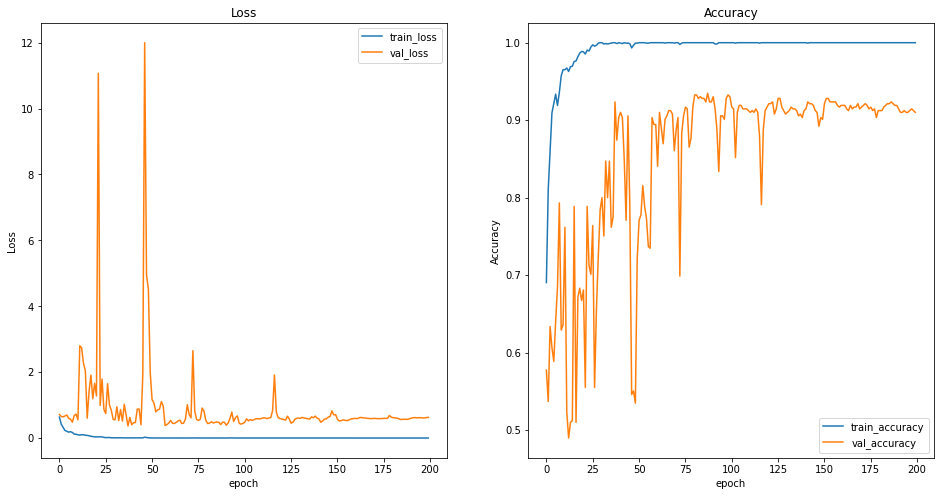

In [10]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [11]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V7_3.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [12]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 1.0% 召回率:  1.0, f1:  1.0
在20%测试集上, accuracy: 0.9348% 召回率: 0.9623430962343096, f1: 0.9406952965235174


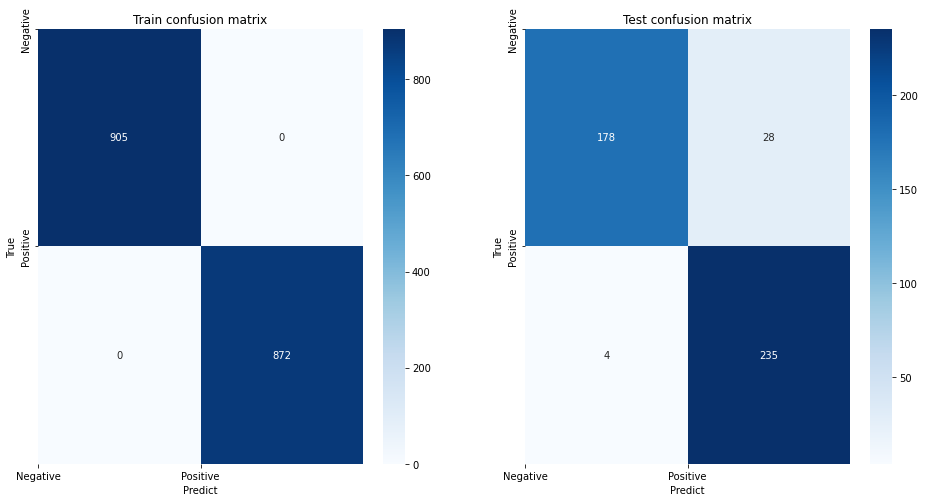

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()